In [5]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from eulers_method import euler_method
from chemical_kinetics import fit

In [24]:
def dy_dx(y):
    return -2 * pow(y, 2)
t_euler, y_euler = euler_method(dy_dx, 0.001, 0, 100, 10000)

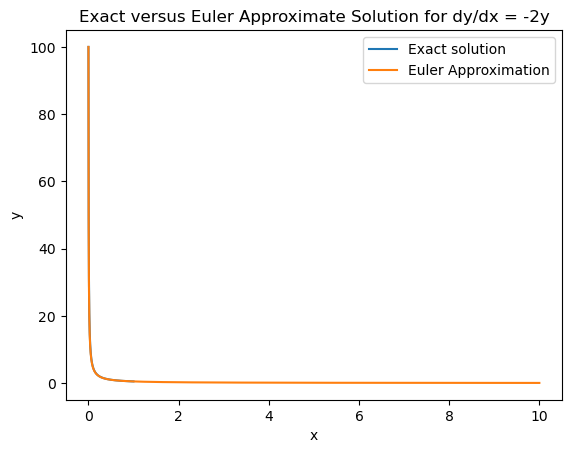

In [25]:
def exact_solution(t):
    return 100/(1 + 200*t)

t = np.arange(0, 1, 0.001)
plt.figure()
plt.plot(t, exact_solution(t), label="Exact solution")
plt.plot(t_euler, y_euler, label="Euler Approximation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Exact versus Euler Approximate Solution for dy/dx = -2y")
plt.savefig("../../data/euler_approx.png")
plt.show()

In [14]:
def reaction_kinetics(s, t, a, b):
    x = s[0]
    y = s[1]
    dy = b * x - (y * (x**2))
    dx = a + (y * (x**2)) - b*x - x
    return dx, dy

In [19]:
tout = np.linspace(0, 10, 100)
s0 = [5, 1]  # initial state vector s
params = 1.5, 4  # A = 1.5, B = 4
s_t = odeint(reaction_kinetics, s0, tout, params)

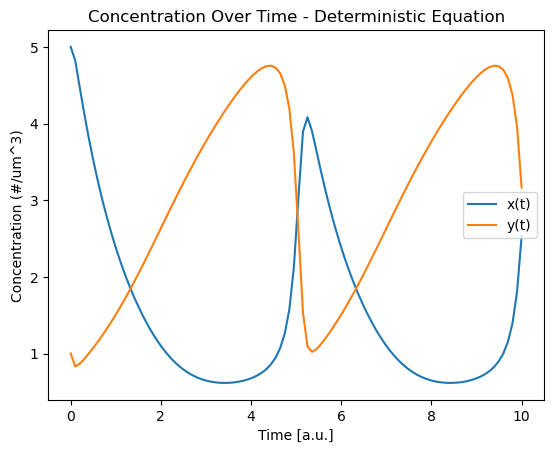

In [21]:
plt.figure()
plt.plot(tout, s_t)
plt.legend(['x(t)', 'y(t)'])
plt.xlabel("Time [a.u.]")
plt.ylabel("Concentration (#/um^3)")
plt.title("Concentration Over Time - Deterministic Equation")
plt.savefig("../../data/reaction_kinetics.png")